# Import depecdencies

In [3]:
import os
import shutil
import matplotlib
import numpy as np
import pandas as pd
import os.path as osp
import seaborn as sns
import os.path as osp
import matplotlib.pyplot as plt
from plottable import Table
from plottable import ColumnDefinition
from utils.plot import draw_stacked_bars
from matplotlib.cm import Greens, Reds
from plottable.cmap import normed_cmap
from metric.level2.entropy import Entropy
from plottable.formatters import decimal_to_percent
from configs.general import EXPERIMENT_INFO_PATH, BASE_DIR,\
      EXPERIMENT_BASE_DIR, EXPERIMENT_COLS, DATA_FILTERING_POLICIES,\
          DATA_RETRIEVAL_POLICIES, PHASES,\
          FILTERING_EXPERIMENT_INFO_PATH, METRICS_BASE_DIR

from metric.level2.loss import Loss


METRIC_NAME = "loss"

# Calculate loss for each experiment 

In [4]:
def load_experiments_with_auc_of_metric(path, index_col):
    experiments_with_auc_of_metric = None
    try:
        experiments_with_auc_of_metric = pd.read_csv(path, index_col=index_col)
    except Exception as e:
        print(e)
    return experiments_with_auc_of_metric

def load_experiments(path, index_col):
    experiments = pd.read_csv(path, index_col=index_col)
    try:
        experiments.drop(columns=['test_acc'], inplace=True)
    except Exception as e:
        print(e)
    return experiments

def filter_out_auc_calculated_experiments(experiments, experiments_with_auc_of_metric):
    experiments['has_auc'] = False
    for idx in experiments_with_auc_of_metric.index:
        if idx in experiments.index:
            experiments.loc[idx, 'has_auc'] = True
    
    return experiments[(experiments['has_auc'] == False)]

In [5]:
experiments = load_experiments(osp.join(BASE_DIR, "experiments.csv"), index_col='index')
experiments['has_auc'] = False
experiments = experiments[(experiments['done'] == True)]
experiments_with_auc_of_metric = load_experiments_with_auc_of_metric(osp.join(METRICS_BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')

if (experiments_with_auc_of_metric is not None) and (not experiments_with_auc_of_metric.empty):
    experiments = filter_out_auc_calculated_experiments(experiments, experiments_with_auc_of_metric)
for metric_agg in ['mean', 'std']:
    for phase in PHASES:
        experiments[f"{METRIC_NAME}-{metric_agg}-{phase}-auc"] = 0.0

for index, row in experiments.iterrows():
    metric = Loss(
        experiment_dir=osp.join(EXPERIMENT_BASE_DIR, *[str(row[col]) for col in EXPERIMENT_COLS]),
        phases=PHASES,
        folds=row['folds'],
        epochs=row['epochs'],
        epoch_skip=2,
        raw_dataset_path=f"/home/vision/Repo/cleanset/dataset/{row['dataset']}/info.csv")

    result = metric.calculate_metric_per_phase(scale=True)
    mean_metric_auc = metric.calculate_auc_per_phase(result, metric_name='mean')
    std_metric_auc = metric.calculate_auc_per_phase(result, metric_name='std')
    for phase in PHASES:
        experiments.at[index, f"{METRIC_NAME}-{'mean'}-{phase}-auc"] = mean_metric_auc[phase]
        experiments.at[index, f"{METRIC_NAME}-{'std'}-{phase}-auc"] = std_metric_auc[phase]
    experiments.at[index, "has_auc"] = True


[Errno 2] No such file or directory: '/home/vision/Repo/cleanset/logs/metrics/loss_auc.csv'


In [7]:
experiments = experiments[(experiments["has_auc"] == True)]
path = osp.join(METRICS_BASE_DIR, f"{METRIC_NAME}_auc.csv")
if osp.exists(path):
    shutil.copy(path, path+".swp")
else:
    os.makedirs(METRICS_BASE_DIR, exist_ok=True)
if experiments_with_auc_of_metric is not None and not experiments_with_auc_of_metric.empty:
    experiments_with_auc_of_metric = experiments_with_auc_of_metric._append(experiments.drop(columns=['has_auc']))
    experiments_with_auc_of_metric.sort_index(inplace=True)
    experiments_with_auc_of_metric.to_csv(path)
else:
    experiments.drop(columns=['has_auc'], inplace=True)
    experiments.sort_index(inplace=True)
    experiments.to_csv(osp.join(path))

# Best Settings with xception model based on entropy AUC

### Plot Best AUC for train and validation phase

In [8]:
experiments_with_auc = pd.read_csv(osp.join(BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')
experiments_with_auc = experiments_with_auc.dropna()
experiments_with_auc = experiments_with_auc[experiments_with_auc['model'] == 'xception']

In [9]:
train_mean_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-mean-train-auc'].idxmax()]
train_std_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-std-train-auc'].idxmax()]
val_mean_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-mean-validation-auc'].idxmax()]
val_std_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-std-validation-auc'].idxmax()]

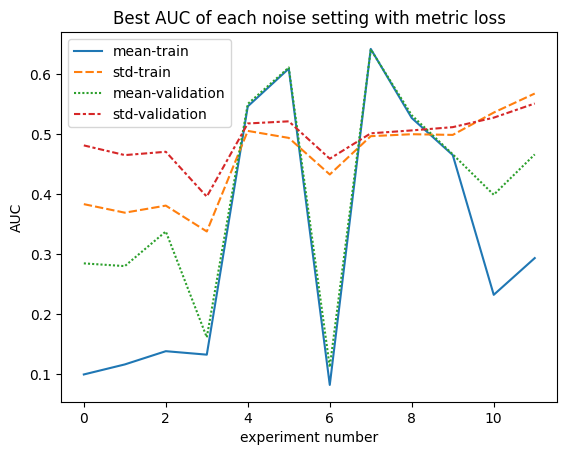

In [10]:
plt.title(f'Best AUC of each noise setting with metric {METRIC_NAME}')
sns.lineplot(
    data=pd.DataFrame(
        {
            f'mean-train': train_mean_max_auc_rows.reset_index()[f'{METRIC_NAME}-mean-train-auc'],
            f'std-train': train_std_max_auc_rows.reset_index()[f'{METRIC_NAME}-std-train-auc'],
            f'mean-validation': val_mean_max_auc_rows.reset_index()[f'{METRIC_NAME}-mean-validation-auc'],
            f'std-validation': val_std_max_auc_rows.reset_index()[f'{METRIC_NAME}-std-validation-auc']
        }))
plt.xlabel('experiment number')
plt.ylabel('AUC')
plt.show()
plt.close()

In [14]:
# based on above plot we select 'train' phase
max_auc_rows = train_std_max_auc_rows.copy()
winner_phase = 'validation'
winner_agg = 'std'

### Plot best settings for each noise setting according to metric

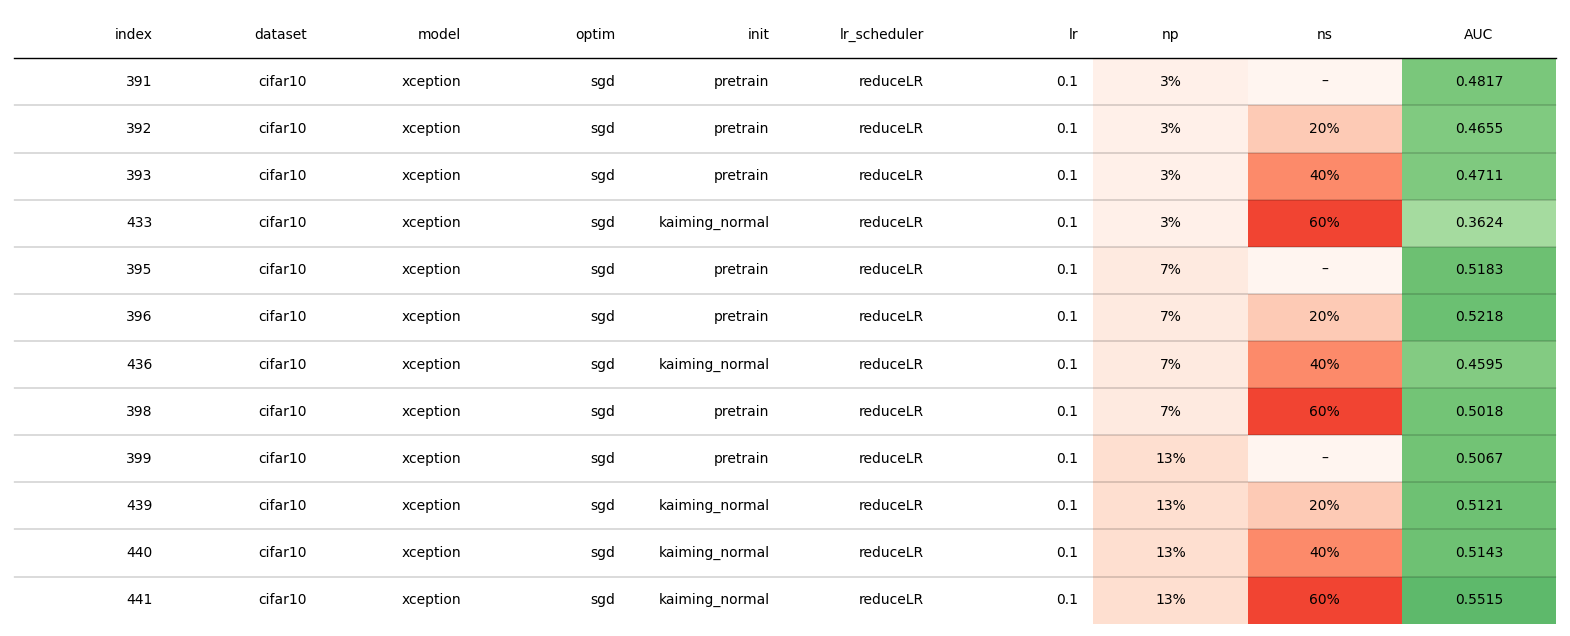

In [15]:
# Init a figure
fig, ax = plt.subplots(figsize=(20, 8))
df = max_auc_rows.copy()
df['np'] = max_auc_rows['np'].str.replace('np=', '').astype(float)
df['ns'] = max_auc_rows['ns'].str.replace('ns=', '').astype(float)
df['lr'] = max_auc_rows['lr'].str.replace('lr=', '').astype(float)
df['AUC'] = max_auc_rows[f'{METRIC_NAME}-{winner_agg}-{winner_phase}-auc'].round(4)
df = df[['dataset','model', 'optim', 'init', 'lr_scheduler', 'lr', 'np', 'ns', 'AUC']]
tab = Table(df, column_definitions=[
    ColumnDefinition(name="AUC", cmap=Greens, textprops= {"ha": "center"}),
    ColumnDefinition(name="np", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="ns", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent)
])

# Display the output
plt.show()

In [16]:
print(f"Top experiments based on metric {METRIC_NAME}: ", df.index.tolist())

Top experiments based on metric loss:  [391, 392, 393, 433, 395, 396, 436, 398, 399, 439, 440, 441]


### Generate database for filtering policies based on this metric

In [19]:
# Generate database for filtering policies based on this metric
new_df = pd.DataFrame()
for experiment_index in max_auc_rows.index.tolist():
    for filtering_policy in DATA_FILTERING_POLICIES:
        for retrieval_policy in DATA_RETRIEVAL_POLICIES:
            new_df = new_df._append({'basic_experiment_index': experiment_index, 'data_filtering_policy': filtering_policy, 'data_retrieval_policy': retrieval_policy}, ignore_index=True)
new_df['based_on'] = METRIC_NAME
new_df['done'] = False
new_df.index.name = 'index'

path = osp.join(BASE_DIR, 'filtering_experiments.csv')
if osp.exists(path):
    shutil.copy(path, path+".swp")
    old_df = pd.read_csv(path, index_col='index')
    new_df = new_df._append(old_df, ignore_index=True)
    new_df = new_df.drop_duplicates(subset=['basic_experiment_index', 'data_filtering_policy', 'data_retrieval_policy', 'based_on'], keep='last').sort_values('basic_experiment_index').reset_index(drop=True)
if not osp.isdir(osp.dirname(path)):
    os.makedirs(osp.dirname(path))
new_df.to_csv(path, index_label='index')

### Write metric per sample for best experiment settings

In [20]:
for index, row in max_auc_rows.iterrows():
    metric = Entropy(
        experiment_dir=osp.join(EXPERIMENT_BASE_DIR, *[str(row[col]) for col in EXPERIMENT_COLS]),
        phases=PHASES,
        folds=row['folds'],
        epochs=row['epochs'],
        epoch_skip=2,
        raw_dataset_path=f"/home/vision/Repo/cleanset/dataset/{row['dataset']}/info.csv")
    path = osp.join(metric.experiment_dir, f"{METRIC_NAME}_per_sample.csv")
    if osp.exists(path):
        print(f"{METRIC_NAME} auc already exist in {path}")
        continue
    result = metric.calculate_metric_per_phase(scale=True)
    result = result[result['phase']==winner_phase].drop(columns=['phase'])
    result.set_index('sample', inplace=True)
    result.to_csv(path, index='sample')

# Best settings based on correctness AUC

In [21]:
experiments_with_auc = pd.read_csv(osp.join(BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')
experiments_with_auc = experiments_with_auc.dropna()
train_mean_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-mean-train-auc'].idxmax()]
train_std_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-std-train-auc'].idxmax()]
val_mean_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-mean-validation-auc'].idxmax()]
val_std_max_auc_rows = experiments_with_auc.loc[experiments_with_auc.groupby(['np', 'ns'])[f'{METRIC_NAME}-std-validation-auc'].idxmax()]

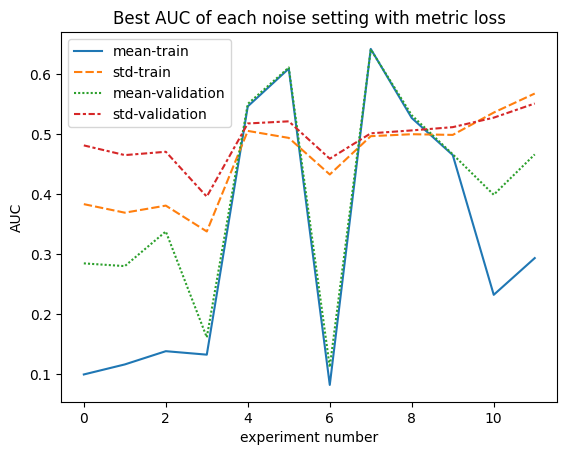

In [22]:
plt.title(f'Best AUC of each noise setting with metric {METRIC_NAME}')
sns.lineplot(
    data=pd.DataFrame(
        {
            f'mean-train': train_mean_max_auc_rows.reset_index()[f'{METRIC_NAME}-mean-train-auc'],
            f'std-train': train_std_max_auc_rows.reset_index()[f'{METRIC_NAME}-std-train-auc'],
            f'mean-validation': val_mean_max_auc_rows.reset_index()[f'{METRIC_NAME}-mean-validation-auc'],
            f'std-validation': val_std_max_auc_rows.reset_index()[f'{METRIC_NAME}-std-validation-auc']
        }))
plt.xlabel('experiment number')
plt.ylabel('AUC')
plt.show()
plt.close()

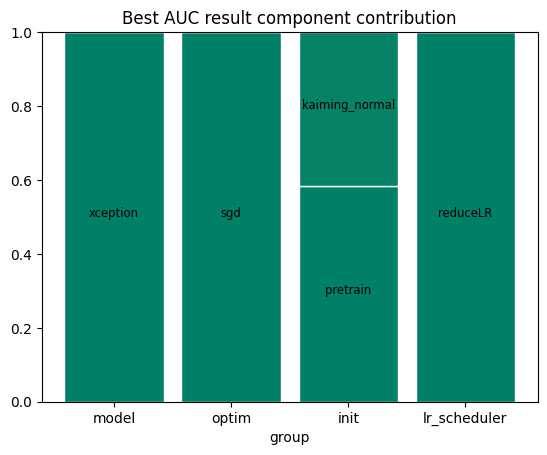

In [23]:
# based on above plot we select 'train' phase
max_auc_rows = train_std_max_auc_rows.copy()
winner_phase = 'train'
winner_agg = 'std'
train_max_auc_rows = max_auc_rows[['model', 'optim', 'init', 'lr_scheduler']]
draw_stacked_bars(train_max_auc_rows)

# Test acc before and after filtering data based on entropy

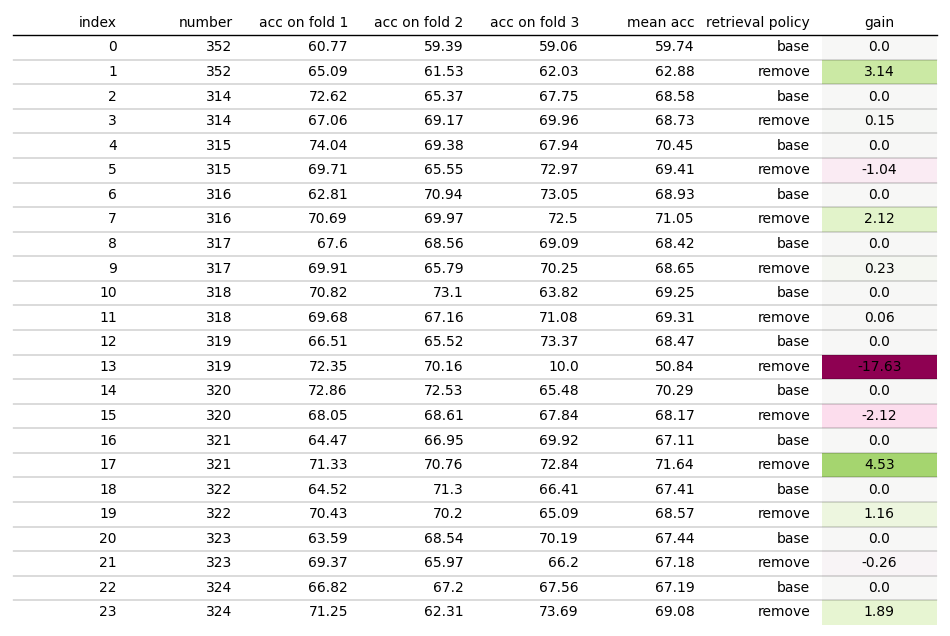

In [10]:
METRIC_NAME = "correctness"
BEST_PHASE = 'train'

result = pd.DataFrame()
try:
    target_experiments_indices = max_auc_rows.index.values()
except:
    target_experiments_indices = [352, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324]

target_experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index').iloc[target_experiments_indices]
filtering_experience = pd.read_csv(FILTERING_EXPERIMENT_INFO_PATH, index_col='index')
filtering_experience = filtering_experience[filtering_experience['based_on'] == 'correctness']
for index, row in target_experiments.iterrows():
    fex = filtering_experience[filtering_experience['basic_experiment_index'].isin([index]) & \
                                (filtering_experience['done'] == True)]
    test_acc = [float(x) for x in row['test_acc'].split()]

    result = result._append({
        'number': index,
        'acc on fold 1': test_acc[0],
        'acc on fold 2': test_acc[1],
        'acc on fold 3': test_acc[2],
        'mean acc': np.mean(test_acc).round(2),
        'retrieval policy': 'base',
        }, ignore_index = True)

    for findex, frow in fex.iterrows():
        test_acc = [float(x) for x in frow['test_acc'].split()]
        result = result._append({
            'number': index,
            'acc on fold 1': test_acc[0],
            'acc on fold 2': test_acc[1],
            'acc on fold 3': test_acc[2],
            'mean acc': np.mean(test_acc).round(2),
            'retrieval policy': frow['data_retrieval_policy'],
            }, ignore_index = True)
        
base_result = pd.DataFrame()
base_result['number'] = result['number']
base_result['base acc'] = 0.0
for index, row in base_result.iterrows():
    base_result.at[index, 'base acc'] = result[(result['number'] == row['number']) & (result['retrieval policy'] == 'base')].iloc[0]['mean acc']
gain = ((result['mean acc'] - base_result['base acc'])).round(2)
result['gain'] = gain

# Init a figure
fig, ax = plt.subplots(figsize=(12, 8))
tab = Table(result, column_definitions=[
    ColumnDefinition(
        name="gain",
        cmap=normed_cmap(
            result["gain"],
            cmap=matplotlib.cm.PiYG, num_stds=2.5),
        textprops={"ha": "center"})
])
# Display the output
plt.show()
